In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
#Read the saved object for decidua:
#Now, h5 class can easily convert it to categoricals. 
dec_results= "/dh-projects/preeclampsia_2022/analysis/placenta_atlas_2022/decidua_anndata/SP014_SP136_decidua_analysis_040322.h5ad"
ldata_dec01= sc.read_h5ad(dec_results)
ldata_dec01.obs['celltype_v5'].cat.categories

Index(['DSC1', 'DSC2', 'IL17RA_dMAC3', 'NKT', 'dDC', 'dEVT', 'dEpC', 'dFB1',
       'dFB2', 'dGranul_new', 'dGranulocyte', 'dLEC', 'dLECp', 'dMAC1',
       'dMAC2', 'dMSC', 'dMono_LYZ', 'dNK1', 'dNK2', 'dNK_prol',
       'dPlasma_cell', 'dSMC', 'dTcell', 'dVEC', 'deported_SCT'],
      dtype='object')

In [3]:
#Read latest object for placenta: 
results_scvi= "/dh-projects/preeclampsia_2022/analysis/spatial_data/SP014_SP082_SP136_placenta_annotations_250322.h5ad"
adata_villi= sc.read_h5ad(results_scvi)
adata_villi.obs['leiden_subclusters_refined02'].cat.categories

Index(['APAhi_tropho', 'PAMM', 'vEB1', 'vEVT', 'vFB1', 'vHBC', 'vHBC_prol',
       'vMC', 'vSCT_1', 'vSCT_2', 'vSCTjuv', 'vTcell', 'vVCT', 'vVCT_prol',
       'vVEC'],
      dtype='object')

In [4]:
ldata_dec= ldata_dec01.raw.to_adata()
ldata_dec.n_obs

66100

In [5]:
ldata_v= adata_villi.raw.to_adata()
ldata_v.n_obs

145637

In [6]:
ldata_v.obs['celltype_final']= ldata_v.obs['leiden_subclusters_refined02']

In [7]:
ldata_dec.obs['celltype_final']= ldata_dec.obs['celltype_v5']

In [8]:
#Concatenate the decidua & villi objects together for computing Pearson correlation between cell types/states: 
adata_all= ldata_dec.concatenate(ldata_v)

In [9]:
adata_all.obs['celltype_final']= adata_all.obs['celltype_final'].astype('category')
adata_all.obs['celltype_final'].cat.categories

Index(['APAhi_tropho', 'DSC1', 'DSC2', 'IL17RA_dMAC3', 'NKT', 'PAMM', 'dDC',
       'dEVT', 'dEpC', 'dFB1', 'dFB2', 'dGranul_new', 'dGranulocyte', 'dLEC',
       'dLECp', 'dMAC1', 'dMAC2', 'dMSC', 'dMono_LYZ', 'dNK1', 'dNK2',
       'dNK_prol', 'dPlasma_cell', 'dSMC', 'dTcell', 'dVEC', 'deported_SCT',
       'vEB1', 'vEVT', 'vFB1', 'vHBC', 'vHBC_prol', 'vMC', 'vSCT_1', 'vSCT_2',
       'vSCTjuv', 'vTcell', 'vVCT', 'vVCT_prol', 'vVEC'],
      dtype='object')

In [10]:
#Rename the cluster names as per the latest manuscript annotations:
adata_all.obs['celltype_final']= adata_all.obs['celltype_final'].map(lambda x: {"APAhi_tropho": "vCTBpf",
"vSCTjuv": "vSTBjuv", "vSCT_1": "vSTB1", "vSCT_2": "vSTB2", "IL17RA_dMAC3": "dMono2", "deported_SCT": "dDSCT",
"dGranul_new": "dBcell", "dNK_prol": "dNKp", "vHBC_prol": "vHBCp", "dMono_LYZ": "dMono1", 
"dGranulocyte": "dGranul", "vVCT_prol": "vCTBp", "vVCT": "vCTB"}.get(x, x)).astype("category")

adata_all.obs['celltype_final'].value_counts()

vSTB1           59211
vCTB            26873
vSTB2           13264
dTcell          10505
dMAC1           10098
dNK1             9682
vCTBp            9508
dEpC             7816
vEB1             7460
vHBC             7154
vFB1             5590
dLEC             4076
dNK2             3531
dMAC2            2897
vSTBjuv          2840
vEVT             2834
dVEC             2756
vCTBpf           2747
vMC              2351
dMono2           2286
vVEC             1972
PAMM             1963
DSC1             1916
dMono1           1750
vTcell           1431
dSMC             1128
NKT              1119
dDSCT            1065
DSC2              708
dEVT              686
dFB1              684
dMSC              665
dFB2              662
dPlasma_cell      551
dLECp             532
vHBCp             439
dNKp              320
dGranul           276
dBcell            263
dDC               128
Name: celltype_final, dtype: int64

In [12]:
#Normalize the matrix after merging:
ldata_norm_int= adata_all.copy()

#Normalize the data:
sc.pp.normalize_total(ldata_norm_int, target_sum=1e4)
#take the logarithm: 
sc.pp.log1p(ldata_norm_int)

In [13]:
annot_key= 'celltype_final' #Set the cell type annotation key for segregating by PC(s) later. 

In [14]:
#Perform  Principal Component Analysis (PCA) on normalized data.  
sc.tl.pca(ldata_norm_int)

In [15]:
#Run as a python script. 
#On notebook, there can be a MemoryError: [Unable to allocate 1.47 GiB for an array with shape (393400934,) and data type int32]
for group in ldata_norm_int.obs[annot_key].cat.categories:
    print(group)
    adata_sub=ldata_norm_int.copy()
    ix= np.in1d(ldata_norm_int.obs[annot_key],group)
    adata_sub=ldata_norm_int.copy()[ix]
    ldata_norm_int.uns['mean_pca_'+group]=np.squeeze(np.asarray(adata_sub.obsm['X_pca'].mean(axis=0).T))
    del adata_sub

vCTBpf
DSC1
DSC2
dMono2
NKT
PAMM
dDC
dEVT
dEpC
dFB1
dFB2
dBcell
dGranul
dLEC
dLECp
dMAC1
dMAC2
dMSC
dMono1
dNK1
dNK2
dNKp
dPlasma_cell
dSMC
dTcell
dVEC
dDSCT
vEB1
vEVT
vFB1
vHBC
vHBCp
vMC
vSTB1
vSTB2
vSTBjuv
vTcell
vCTB
vCTBp
vVEC


In [16]:
adata_all.obs['celltype_final'].cat.categories #look at the category names. 

Index(['vCTBpf', 'DSC1', 'DSC2', 'dMono2', 'NKT', 'PAMM', 'dDC', 'dEVT',
       'dEpC', 'dFB1', 'dFB2', 'dBcell', 'dGranul', 'dLEC', 'dLECp', 'dMAC1',
       'dMAC2', 'dMSC', 'dMono1', 'dNK1', 'dNK2', 'dNKp', 'dPlasma_cell',
       'dSMC', 'dTcell', 'dVEC', 'dDSCT', 'vEB1', 'vEVT', 'vFB1', 'vHBC',
       'vHBCp', 'vMC', 'vSTB1', 'vSTB2', 'vSTBjuv', 'vTcell', 'vCTB', 'vCTBp',
       'vVEC'],
      dtype='object')

In [17]:
#Create an aggregated data frame combining all cell types/states (taking their mean PC values)
d = {
    'vCTBp':ldata_norm_int.uns['mean_pca_vCTBp'], 
     'vCTB':ldata_norm_int.uns['mean_pca_vCTB'], 
     'vCTBpf':ldata_norm_int.uns['mean_pca_vCTBpf'], 
     'vSTBjuv':ldata_norm_int.uns['mean_pca_vSTBjuv'], 
     'vSTB1':ldata_norm_int.uns['mean_pca_vSTB1'], 
     'vSTB2':ldata_norm_int.uns['mean_pca_vSTB2'],
     'dDSCT': ldata_norm_int.uns['mean_pca_dDSCT'], 
     'vCCT': ldata_norm_int.uns['mean_pca_vEVT'], 
     'dEVT': ldata_norm_int.uns['mean_pca_dEVT'], 
     'vPAMM':ldata_norm_int.uns['mean_pca_PAMM'], 
     'vHBC':ldata_norm_int.uns['mean_pca_vHBC'],
     'vHBCp':ldata_norm_int.uns['mean_pca_vHBCp'], 
     'dMAC1':ldata_norm_int.uns['mean_pca_dMAC1'],
     'dMAC2':ldata_norm_int.uns['mean_pca_dMAC2'],
     'dMono1':ldata_norm_int.uns['mean_pca_dMono1'], 
     'dMono2':ldata_norm_int.uns['mean_pca_dMono2'], 
     'dDC':ldata_norm_int.uns['mean_pca_dDC'],
     'vTcell': ldata_norm_int.uns['mean_pca_vTcell'], 
     'dTcell':ldata_norm_int.uns['mean_pca_dTcell'], 
     'vVEC': ldata_norm_int.uns['mean_pca_vVEC'], 
     'dVEC': ldata_norm_int.uns['mean_pca_dVEC'],
     'dLEC': ldata_norm_int.uns['mean_pca_dLEC'],
     'dLECP':ldata_norm_int.uns['mean_pca_dLECp'],
     'vFB': ldata_norm_int.uns['mean_pca_vFB1'], 
     'dFB1':ldata_norm_int.uns['mean_pca_dFB1'],
     'dFB2':ldata_norm_int.uns['mean_pca_dFB2'],
     'vMC': ldata_norm_int.uns['mean_pca_vMC'], 
     'dSMC':ldata_norm_int.uns['mean_pca_dSMC'],
     'DSC1':ldata_norm_int.uns['mean_pca_DSC1'],
     'DSC2':ldata_norm_int.uns['mean_pca_DSC2'],
     'dMSC':ldata_norm_int.uns['mean_pca_dMSC'],
     'dNK1':ldata_norm_int.uns['mean_pca_dNK1'],
     'dNK2':ldata_norm_int.uns['mean_pca_dNK2'],
     'dNKp': ldata_norm_int.uns['mean_pca_dNKp'], 
     'dGranul':ldata_norm_int.uns['mean_pca_dGranul'], 
     'dBcell':ldata_norm_int.uns['mean_pca_dBcell'],
     'dPC': ldata_norm_int.uns['mean_pca_dPlasma_cell'], 
    'vEB':ldata_norm_int.uns['mean_pca_vEB1'],
    'dEpC':ldata_norm_int.uns['mean_pca_dEpC']
                      }

df = pd.DataFrame(data=d)

In [20]:
#Calculate Pearson correlation:

#No need to sort the df since we'll both row/column cluster. 
df_cor_pearson=np.corrcoef(df.T)
names=df.columns
df_cor_named_pearson=pd.DataFrame(df_cor_pearson,index=names,columns=names)
df_cor_named_pearson.head()

,vCTBp,vCTB,vCTBpf,vSTBjuv,vSTB1,vSTB2,dDSCT,vCCT,dEVT,vPAMM,...,DSC2,dMSC,dNK1,dNK2,dNKp,dGranul,dBcell,dPC,vEB,dEpC
vCTBp,1.000000,0.899327,0.386710,0.086781,-0.439388,-0.613359,-0.385752,0.509731,-0.095917,-0.141199,...,-0.322328,-0.005474,-0.254875,-0.309916,0.146349,-0.288816,-0.086196,-0.293815,-0.198511,0.035563
vCTB,0.899327,1.000000,0.513213,0.105425,-0.378146,-0.596271,-0.332738,0.419909,-0.139197,-0.189134,...,-0.376418,-0.047463,-0.327842,-0.382168,-0.071873,-0.372009,-0.166810,-0.336549,-0.249423,0.019574
vCTBpf,0.386710,0.513213,1.000000,0.261976,0.103261,-0.111445,0.120166,0.140581,-0.227307,-0.292743,...,-0.292230,-0.268810,-0.371106,-0.402042,-0.279036,-0.477434,-0.330504,-0.349197,-0.229308,-0.135372
vSTBjuv,0.086781,0.105425,0.261976,1.000000,0.423977,0.303030,0.349925,0.053857,0.260675,-0.443103,...,0.251858,-0.225913,-0.420273,-0.435644,-0.487288,-0.592130,-0.531213,-0.288117,-0.215987,-0.251275
vSTB1,-0.439388,-0.378146,0.103261,0.423977,1.000000,0.744624,0.914911,-0.253199,-0.230302,-0.520263,...,-0.219074,-0.440659,-0.454732,-0.463955,-0.600427,-0.608406,-0.590224,-0.299159,-0.301227,-0.338449


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

/home/debnatho/anaconda3/envs/scvi_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "center" which is no longer supported as of 3.3 and will become an error two minor releases later
  import sys


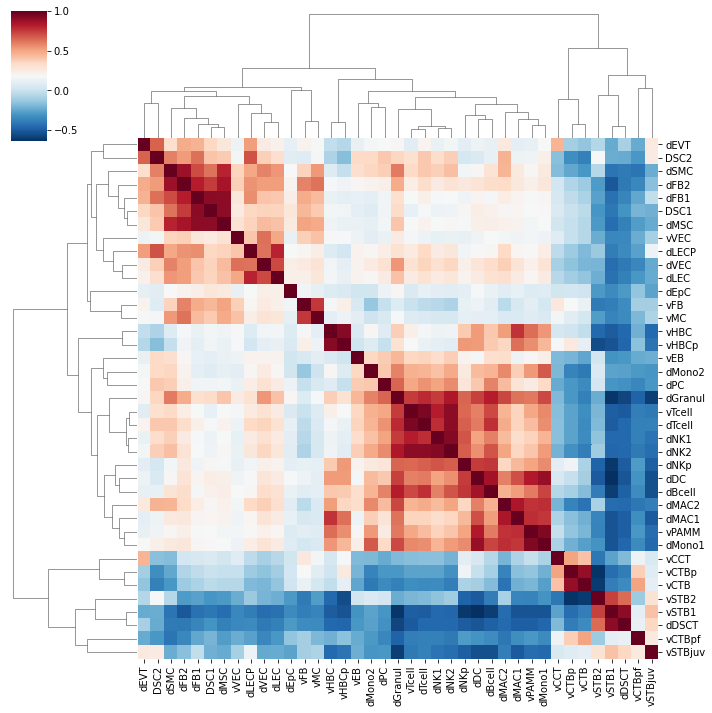

In [33]:
#Extended Data figure 2D: 
plt.rcParams['figure.figsize']= (60,60)

#Plot a matrix dataset as a hierarchically-clustered heatmap.
#Show all cluster labels. 
ax= sns.clustermap(df_cor_named_pearson,cmap='RdBu_r',method='average', col_cluster=True, row_cluster=True, yticklabels=True)
plt.savefig("Celltype_PearsonCorr_manuscript_v1.pdf", dpi=400, orientation='landscape', bbox_inches='tight', center=0)